In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
from diffusers import DDPMScheduler, UNet2DModel, DDIMScheduler
import matplotlib.pyplot as plt
from datasets import Dataset
import os
from PIL import Image
import numpy as np
import torch.nn.functional as F

C:\Users\fomka\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("spandan2/cats-faces-64x64-for-generative-models")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\fomka\.cache\kagglehub\datasets\spandan2\cats-faces-64x64-for-generative-models\versions\1


In [2]:
BATCH_SIZE = 16
IMAGE_SIZE = 64
NUM_EPOCHS = 100
LEARNING_RATE = 3e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [162]:
def load_images_from_folder(folder_path):
    images = []
    # Ищем изображения в различных подпапках
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                images.append(os.path.join(root, file))
    return images

In [163]:
image_paths = load_images_from_folder(path)
print(f"Found {len(image_paths)} images")

# Создаем Hugging Face dataset
def create_dataset(image_paths):
    def generator():
        for path in image_paths:
            try:
                image = Image.open(path)
                yield {"image": image, "path": path}
            except Exception as e:
                print(f"Error loading {path}: {e}")
                continue

    return Dataset.from_generator(generator)

dataset = create_dataset(image_paths).shuffle(seed=42).select(range(20000))

Found 31494 images


In [3]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

def transform_examples(examples):
    images = []
    for image in examples["image"]:
        try:
            if image.mode != 'RGB':
                image = image.convert('RGB')
            images.append(transform(image))
        except:
            images.append(torch.zeros(3, IMAGE_SIZE, IMAGE_SIZE))
    return {"image": images}

dataset.set_transform(transform_examples)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
print(f"Dataset loaded: {len(dataset)} images")

NameError: name 'dataset' is not defined

In [4]:
model = UNet2DModel(
    sample_size=IMAGE_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 256, 512),
    down_block_types=(
        "DownBlock2D",       # 64 -> 128
        "AttnDownBlock2D",   # 128 -> 256
        "AttnDownBlock2D",   # 256 -> 512
    ),
    up_block_types=(
        "AttnUpBlock2D",     # 512 -> 256
        "AttnUpBlock2D",     # 256 -> 128
        "UpBlock2D",         # 128 -> 64
    ),
)

noise_scheduler = DDIMScheduler(
    num_train_timesteps=2000,
    beta_schedule='squaredcos_cap_v2',
    clip_sample=False,
    set_alpha_to_one=False,
)

model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [9]:
import torch
from pathlib import Path

checkpoint_path = Path("./checkpoints/checkpoint_epoch_55.pt")  # замените на путь к вашему файлу
ckpt = torch.load(checkpoint_path, map_location="cpu")
ckpt['config'] = model.config
ckpt['scheduler_config'] = noise_scheduler.config
torch.save(ckpt, checkpoint_path.with_name(checkpoint_path.stem + "_with_config" + checkpoint_path.suffix))

In [166]:
def plot_images(images, title="Generated Images"):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
    if len(images) == 1:
        axes = [axes]

    for i, img in enumerate(images):
        img = img.permute(1, 2, 0).cpu().numpy()
        img = img * 0.5 + 0.5  # Денормализация
        img = np.clip(img, 0, 1)
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [167]:
import os
from tqdm import tqdm
import torch.nn.functional as F

# Создаём папку для чекпоинтов
os.makedirs("checkpoints", exist_ok=True)

model.train()
global_step = 0
print('Start training')

best_loss = float('inf')  # Для отслеживания лучшей модели

for epoch in range(NUM_EPOCHS):
    epoch_loss = 0.0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")

    for batch in progress_bar:
        clean_images = batch["image"].to(DEVICE)

        # Пропускаем батчи с проблемными изображениями
        if clean_images.shape[0] < 2:
            continue

        # Генерация шума
        noise = torch.randn_like(clean_images)
        batch_size = clean_images.shape[0]

        # Выбор случайных временных шагов
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps,
            (batch_size,), device=DEVICE
        ).long()

        # Добавление шума к изображениям
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Предсказание шума
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Вычисление потерь
        loss = F.mse_loss(noise_pred, noise)

        # Обратное распространение
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        global_step += 1

        progress_bar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "avg_loss": f"{epoch_loss/(global_step % len(dataloader) + 1):.4f}"
        })

    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch {epoch+1} completed. Average loss: {avg_loss:.4f}")

    # Сохраняем чекпоинт каждые 5 эпох
    if (epoch + 1) % 5 == 0:
        checkpoint_path = f"checkpoints/checkpoint_epoch_{epoch+1}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, checkpoint_path)
        print(f"Saved checkpoint: {checkpoint_path}")

        # Сохраняем лучшую модель
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model_path = f"checkpoints/best_model.pt"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, best_model_path)
            print(f"Saved best model: {best_model_path}")

# Финальная генерация изображений
print("Final image generation...")
model.eval()

Start training


Epoch 1/100: 100%|██████████| 1250/1250 [10:10<00:00,  2.05it/s, loss=0.0283, avg_loss=123.2046]


Epoch 1 completed. Average loss: 0.0986


Epoch 2/100: 100%|██████████| 1250/1250 [10:09<00:00,  2.05it/s, loss=0.0513, avg_loss=80.4319]


Epoch 2 completed. Average loss: 0.0643


Epoch 3/100: 100%|██████████| 1250/1250 [10:21<00:00,  2.01it/s, loss=0.0643, avg_loss=75.8627]


Epoch 3 completed. Average loss: 0.0607


Epoch 4/100: 100%|██████████| 1250/1250 [10:17<00:00,  2.03it/s, loss=0.0543, avg_loss=71.4811]


Epoch 4 completed. Average loss: 0.0572


Epoch 5/100: 100%|██████████| 1250/1250 [10:10<00:00,  2.05it/s, loss=0.0711, avg_loss=70.7325]


Epoch 5 completed. Average loss: 0.0566
Saved checkpoint: checkpoints/checkpoint_epoch_5.pt
Saved best model: checkpoints/best_model.pt


Epoch 6/100: 100%|██████████| 1250/1250 [10:11<00:00,  2.05it/s, loss=0.0543, avg_loss=68.2572]


Epoch 6 completed. Average loss: 0.0546


Epoch 7/100: 100%|██████████| 1250/1250 [10:16<00:00,  2.03it/s, loss=0.0492, avg_loss=68.0643]


Epoch 7 completed. Average loss: 0.0545


Epoch 8/100: 100%|██████████| 1250/1250 [10:10<00:00,  2.05it/s, loss=0.0539, avg_loss=66.6093]


Epoch 8 completed. Average loss: 0.0533


Epoch 9/100: 100%|██████████| 1250/1250 [10:15<00:00,  2.03it/s, loss=0.0268, avg_loss=65.0799]


Epoch 9 completed. Average loss: 0.0521


Epoch 10/100: 100%|██████████| 1250/1250 [10:10<00:00,  2.05it/s, loss=0.0287, avg_loss=67.6441]


Epoch 10 completed. Average loss: 0.0541
Saved checkpoint: checkpoints/checkpoint_epoch_10.pt
Saved best model: checkpoints/best_model.pt


Epoch 11/100: 100%|██████████| 1250/1250 [10:10<00:00,  2.05it/s, loss=0.0614, avg_loss=65.9865]


Epoch 11 completed. Average loss: 0.0528


Epoch 12/100: 100%|██████████| 1250/1250 [10:10<00:00,  2.05it/s, loss=0.0472, avg_loss=65.2114]


Epoch 12 completed. Average loss: 0.0522


Epoch 13/100: 100%|██████████| 1250/1250 [10:10<00:00,  2.05it/s, loss=0.0299, avg_loss=65.3588]


Epoch 13 completed. Average loss: 0.0523


Epoch 14/100: 100%|██████████| 1250/1250 [10:13<00:00,  2.04it/s, loss=0.0678, avg_loss=64.4367]


Epoch 14 completed. Average loss: 0.0515


Epoch 15/100: 100%|██████████| 1250/1250 [10:16<00:00,  2.03it/s, loss=0.0769, avg_loss=64.4211]


Epoch 15 completed. Average loss: 0.0515
Saved checkpoint: checkpoints/checkpoint_epoch_15.pt
Saved best model: checkpoints/best_model.pt


Epoch 16/100: 100%|██████████| 1250/1250 [10:10<00:00,  2.05it/s, loss=0.0642, avg_loss=64.6476]


Epoch 16 completed. Average loss: 0.0517


Epoch 17/100: 100%|██████████| 1250/1250 [10:10<00:00,  2.05it/s, loss=0.0354, avg_loss=64.1041]


Epoch 17 completed. Average loss: 0.0513


Epoch 18/100: 100%|██████████| 1250/1250 [10:10<00:00,  2.05it/s, loss=0.0341, avg_loss=63.5638]


Epoch 18 completed. Average loss: 0.0509


Epoch 19/100: 100%|██████████| 1250/1250 [10:10<00:00,  2.05it/s, loss=0.0274, avg_loss=63.3324]


Epoch 19 completed. Average loss: 0.0507


Epoch 20/100: 100%|██████████| 1250/1250 [10:26<00:00,  2.00it/s, loss=0.0367, avg_loss=63.6651]


Epoch 20 completed. Average loss: 0.0509
Saved checkpoint: checkpoints/checkpoint_epoch_20.pt
Saved best model: checkpoints/best_model.pt


Epoch 21/100: 100%|██████████| 1250/1250 [10:09<00:00,  2.05it/s, loss=0.0297, avg_loss=62.6555]


Epoch 21 completed. Average loss: 0.0501


Epoch 22/100: 100%|██████████| 1250/1250 [10:09<00:00,  2.05it/s, loss=0.0413, avg_loss=63.5179]


Epoch 22 completed. Average loss: 0.0508


Epoch 23/100: 100%|██████████| 1250/1250 [10:10<00:00,  2.05it/s, loss=0.0531, avg_loss=62.2500]


Epoch 23 completed. Average loss: 0.0498


Epoch 24/100: 100%|██████████| 1250/1250 [10:10<00:00,  2.05it/s, loss=0.0776, avg_loss=62.1882]


Epoch 24 completed. Average loss: 0.0498


Epoch 25/100: 100%|██████████| 1250/1250 [10:16<00:00,  2.03it/s, loss=0.0417, avg_loss=62.8199]


Epoch 25 completed. Average loss: 0.0503
Saved checkpoint: checkpoints/checkpoint_epoch_25.pt
Saved best model: checkpoints/best_model.pt


Epoch 26/100: 100%|██████████| 1250/1250 [10:10<00:00,  2.05it/s, loss=0.0442, avg_loss=62.6553]


Epoch 26 completed. Average loss: 0.0501


Epoch 27/100: 100%|██████████| 1250/1250 [10:17<00:00,  2.03it/s, loss=0.0588, avg_loss=62.5773]


Epoch 27 completed. Average loss: 0.0501


Epoch 28/100: 100%|██████████| 1250/1250 [10:16<00:00,  2.03it/s, loss=0.0620, avg_loss=62.4675]


Epoch 28 completed. Average loss: 0.0500


Epoch 29/100: 100%|██████████| 1250/1250 [10:10<00:00,  2.05it/s, loss=0.0556, avg_loss=61.1375]


Epoch 29 completed. Average loss: 0.0489


Epoch 30/100: 100%|██████████| 1250/1250 [10:10<00:00,  2.05it/s, loss=0.0524, avg_loss=60.9833]


Epoch 30 completed. Average loss: 0.0488
Saved checkpoint: checkpoints/checkpoint_epoch_30.pt
Saved best model: checkpoints/best_model.pt


Epoch 31/100: 100%|██████████| 1250/1250 [10:10<00:00,  2.05it/s, loss=0.0809, avg_loss=59.9369]


Epoch 31 completed. Average loss: 0.0479


Epoch 32/100: 100%|██████████| 1250/1250 [10:10<00:00,  2.05it/s, loss=0.0608, avg_loss=61.8303]


Epoch 32 completed. Average loss: 0.0495


Epoch 33/100: 100%|██████████| 1250/1250 [10:10<00:00,  2.05it/s, loss=0.0352, avg_loss=60.9313]


Epoch 33 completed. Average loss: 0.0487


Epoch 34/100: 100%|██████████| 1250/1250 [10:10<00:00,  2.05it/s, loss=0.0444, avg_loss=61.9752]


Epoch 34 completed. Average loss: 0.0496


Epoch 35/100: 100%|██████████| 1250/1250 [10:15<00:00,  2.03it/s, loss=0.0520, avg_loss=60.5019]


Epoch 35 completed. Average loss: 0.0484
Saved checkpoint: checkpoints/checkpoint_epoch_35.pt
Saved best model: checkpoints/best_model.pt


Epoch 36/100: 100%|██████████| 1250/1250 [10:09<00:00,  2.05it/s, loss=0.0438, avg_loss=61.4311]


Epoch 36 completed. Average loss: 0.0491


Epoch 37/100: 100%|██████████| 1250/1250 [10:18<00:00,  2.02it/s, loss=0.0248, avg_loss=58.0099]


Epoch 37 completed. Average loss: 0.0464


Epoch 38/100: 100%|██████████| 1250/1250 [10:10<00:00,  2.05it/s, loss=0.0342, avg_loss=60.5060]


Epoch 38 completed. Average loss: 0.0484


Epoch 39/100: 100%|██████████| 1250/1250 [10:10<00:00,  2.05it/s, loss=0.0675, avg_loss=58.6628]


Epoch 39 completed. Average loss: 0.0469


Epoch 40/100: 100%|██████████| 1250/1250 [10:10<00:00,  2.05it/s, loss=0.0859, avg_loss=60.6972]


Epoch 40 completed. Average loss: 0.0486
Saved checkpoint: checkpoints/checkpoint_epoch_40.pt


Epoch 41/100: 100%|██████████| 1250/1250 [10:14<00:00,  2.03it/s, loss=0.0653, avg_loss=59.2599]


Epoch 41 completed. Average loss: 0.0474


Epoch 42/100: 100%|██████████| 1250/1250 [10:10<00:00,  2.05it/s, loss=0.0329, avg_loss=60.2942]


Epoch 42 completed. Average loss: 0.0482


Epoch 43/100: 100%|██████████| 1250/1250 [10:10<00:00,  2.05it/s, loss=0.0412, avg_loss=59.1908]


Epoch 43 completed. Average loss: 0.0474


Epoch 44/100: 100%|██████████| 1250/1250 [10:10<00:00,  2.05it/s, loss=0.0284, avg_loss=59.0304]


Epoch 44 completed. Average loss: 0.0472


Epoch 45/100: 100%|██████████| 1250/1250 [10:10<00:00,  2.05it/s, loss=0.0360, avg_loss=58.6685]


Epoch 45 completed. Average loss: 0.0469
Saved checkpoint: checkpoints/checkpoint_epoch_45.pt
Saved best model: checkpoints/best_model.pt


Epoch 46/100: 100%|██████████| 1250/1250 [10:23<00:00,  2.00it/s, loss=0.0389, avg_loss=58.4065]


Epoch 46 completed. Average loss: 0.0467


Epoch 47/100: 100%|██████████| 1250/1250 [10:14<00:00,  2.03it/s, loss=0.0559, avg_loss=57.2220]


Epoch 47 completed. Average loss: 0.0458


Epoch 48/100: 100%|██████████| 1250/1250 [11:30<00:00,  1.81it/s, loss=0.0513, avg_loss=57.7440]


Epoch 48 completed. Average loss: 0.0462


Epoch 49/100: 100%|██████████| 1250/1250 [11:51<00:00,  1.76it/s, loss=0.0653, avg_loss=58.7765]


Epoch 49 completed. Average loss: 0.0470


Epoch 50/100: 100%|██████████| 1250/1250 [11:45<00:00,  1.77it/s, loss=0.0313, avg_loss=58.1926]


Epoch 50 completed. Average loss: 0.0466
Saved checkpoint: checkpoints/checkpoint_epoch_50.pt
Saved best model: checkpoints/best_model.pt


Epoch 51/100: 100%|██████████| 1250/1250 [11:50<00:00,  1.76it/s, loss=0.0638, avg_loss=58.8325]


Epoch 51 completed. Average loss: 0.0471


Epoch 52/100: 100%|██████████| 1250/1250 [11:49<00:00,  1.76it/s, loss=0.0513, avg_loss=57.6203]


Epoch 52 completed. Average loss: 0.0461


Epoch 53/100: 100%|██████████| 1250/1250 [13:01<00:00,  1.60it/s, loss=0.0628, avg_loss=56.7802]


Epoch 53 completed. Average loss: 0.0454


Epoch 54/100: 100%|██████████| 1250/1250 [13:47<00:00,  1.51it/s, loss=0.0490, avg_loss=57.9011]


Epoch 54 completed. Average loss: 0.0463


Epoch 55/100: 100%|██████████| 1250/1250 [13:39<00:00,  1.53it/s, loss=0.0768, avg_loss=56.5720]


Epoch 55 completed. Average loss: 0.0453
Saved checkpoint: checkpoints/checkpoint_epoch_55.pt
Saved best model: checkpoints/best_model.pt


Epoch 56/100: 100%|██████████| 1250/1250 [11:34<00:00,  1.80it/s, loss=0.0267, avg_loss=55.0630]


Epoch 56 completed. Average loss: 0.0441


Epoch 57/100: 100%|██████████| 1250/1250 [14:09<00:00,  1.47it/s, loss=0.0312, avg_loss=56.4383]


Epoch 57 completed. Average loss: 0.0452


Epoch 58/100: 100%|██████████| 1250/1250 [16:41<00:00,  1.25it/s, loss=0.0546, avg_loss=56.5429]


Epoch 58 completed. Average loss: 0.0452


Epoch 59/100: 100%|██████████| 1250/1250 [09:58<00:00,  2.09it/s, loss=0.0343, avg_loss=56.0217]


Epoch 59 completed. Average loss: 0.0448


Epoch 60/100: 100%|██████████| 1250/1250 [17:52<00:00,  1.17it/s, loss=0.0581, avg_loss=55.5389]


Epoch 60 completed. Average loss: 0.0444
Saved checkpoint: checkpoints/checkpoint_epoch_60.pt
Saved best model: checkpoints/best_model.pt


Epoch 61/100:   4%|▍         | 50/1250 [01:22<32:57,  1.65s/it, loss=0.0269, avg_loss=0.0416]  


KeyboardInterrupt: 

Final Generation: 100%|██████████| 5/5 [00:00<00:00, 17.12it/s]


Generated Cat Images:


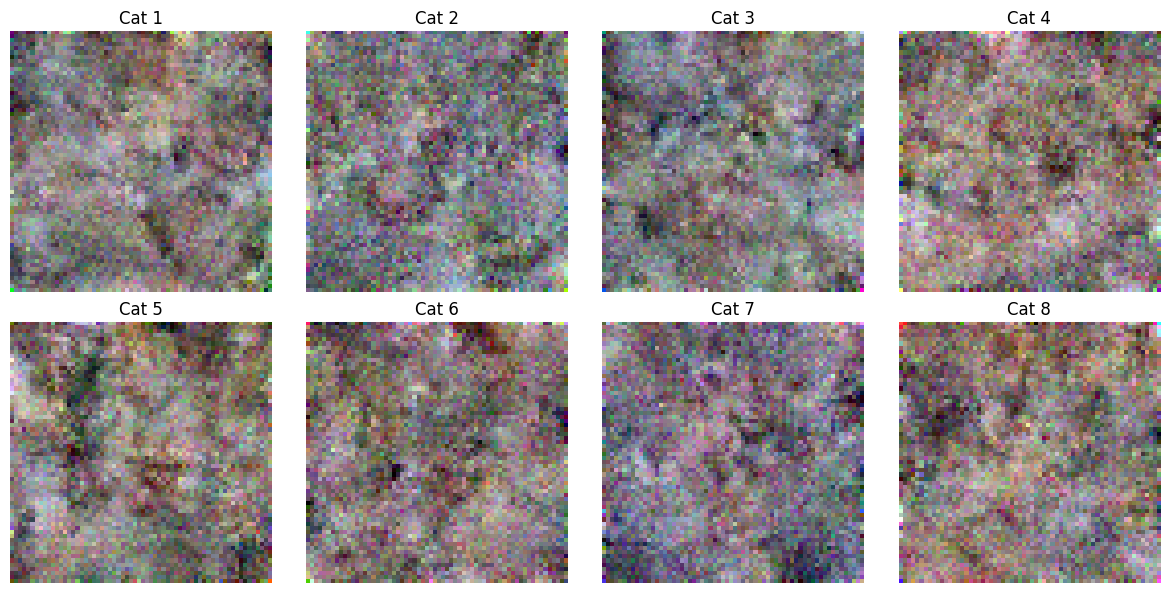

In [154]:
num_generate = 8

with torch.no_grad():
    # Создаем случайный шум
    noise = torch.randn(num_generate, 3, IMAGE_SIZE, IMAGE_SIZE).to(DEVICE)

    # Устанавливаем количество шагов генерации
    noise_scheduler.set_timesteps(5)  # например, 50 шагов

    # Процесс денойзинга
    for t in tqdm(noise_scheduler.timesteps, desc="Final Generation"):
        residual = model(noise, t, return_dict=False)[0]  # исправлено
        noise = noise_scheduler.step(residual, t, noise).prev_sample

    generated_images = noise

# Визуализация
print("Generated Cat Images:")
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for i in range(min(num_generate, len(axes))):
    img = generated_images[i].permute(1, 2, 0).cpu().numpy()
    img = img * 0.5 + 0.5  # Денормализация
    img = np.clip(img, 0, 1)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Cat {i+1}")

plt.tight_layout()
plt.show()